<a href="https://colab.research.google.com/github/benon33/w207-final/blob/main/Final%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Executive Summary 
##### **Context**: As smartphones have become more accessible across the world, social media outlets, such as Twitter, have become important means of communicating during times of an emergency. As a result, more organizations are interested in tracking conversations in this space to respond more quickly.

**Problem**: However, a user's intent in a tweet isn't always clear. Words, such as "ablaze", can be used in multiple contexts. It can be descriptive of a sunset or it could be indicative of something more serious, like a forest fire. 

##### **Approach**: For this project, we will use a data set of twitter posts, found on [Kaggle](https://www.kaggle.com/c/nlp-getting-started). The goal is to identify an algorithm that most accuractely classifies a tweet as indicative of a real disaster or not a real disaster. 

In [45]:
%matplotlib inline

!sudo pip install geonamescache

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import *
from sklearn import metrics

# SK-learn Decomp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# NLP processors
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# TODO: this package nltk.download(wordnet) is for lemmatize to work
# The download did not work so we have to use the below code.. lol

# Please run this code and SSL will pop up a window for you to choose a
# Module to download, click 'all packages' and scroll down
# and select 'wordnet'. You only need to download it once. 
# Not tested in Google Colab :3
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download()


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

# Exploratory Data Analysis: 
First, we will read in the "train" dataset, which contains the correct labels. We will split the data 50/50 between train and dev (or test). For ease of analysis and text processing, the data will be further split into "pos" (label = 1) and "neg" (label = 0) dataframes and text only. 

In [8]:
#read in data
# df = pd.read_csv(r'C:\Users\lwu31\OneDrive - JNJ\Documents\train.csv')
df = pd.read_csv('data/nlp-getting-started/train.csv')
# sample the data, acts as shuffling the data on row

#50/50 split between train and dev
# allocate more for traiing if we do it this way, i'll run some
# analysis to see if my cluster bootstrap can imrpove the models we run.
numtest = int(len(df)/3.5)
df_train = df[numtest:].reset_index(drop=True)
df_test = df[:int(numtest/2)].reset_index(drop=True)
df_dev = df[int(numtest/2):numtest].reset_index(drop=True)

train_data, train_label = df_train.text, df_train.target
dev_data, dev_label = df_dev.text, df_dev.target
test_data, test_label = df_test.text, df_test.target

#split into disaster and non disaster data
df_neg = df_train.loc[df_train.target == 0]
df_pos = df_train.loc[df_train.target == 1]

#split into disaster and nondisaster tweets only
neg_text = df_neg.text
pos_text = df_pos.text

print("Some data metrics\n")
print("Shape of train data:", df_train.shape)
print("\nMissing data in each column:\n" + str(df.isnull().sum()))
print("\nNumber of disaster tweets:\n"+ str(train_label.value_counts()))

FileNotFoundError: ignored

In [17]:
#read in data 
train_data =  pd.read_csv('train.csv')

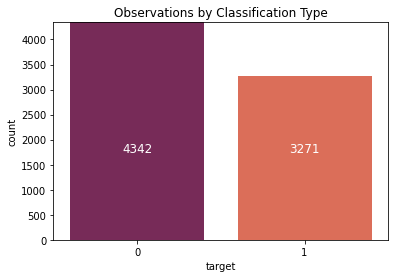

In [18]:
#CREDIT TO SOURCES: 
#https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart 

#explore distribution of dataset 
sns.countplot(x = train_data['target'], palette = 'rocket')
ax = plt.gca()
y_max = train_data['target'].value_counts().max() 
ax.set_ylim([0, round(y_max)])
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., 1700, '%d' % int(p.get_height()), 
            fontsize=12, color='white', ha='center', va= 'bottom')
plt.title("Observations by Classification Type")
plt.show()

## Understanding Duplicate Data

There are 110 tweets in this dataset. When we explored further, we saw that duplicate tweets were not always classified in the same way. As a result, we decided to drop duplicate tweets from the training set to improve our model accuracy.

In [28]:
duplct_cnt = len(train_data['text'])-len(train_data['text'].drop_duplicates())
df['duplicate_tweet'] = np.where(df['text'].duplicated(keep=False), 'yes', 'no')
print('The most common duplicate tweets are:')
df[df.duplicate_tweet == 'yes'].pivot_table(index='text', values='target', aggfunc='count').sort_values(by='target', ascending=False).head(5)


The most common duplicate tweets are:


,target
text,
11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,10
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,6
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',6
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,6
Madhya Pradesh Train Derailment: Village Youth Saved Many Lives,5


In [29]:
dups = df[df.duplicate_tweet == 'yes']
print('Duplicate tweets classification:')
dups[['id', 'text', 'target']].sort_values(by='text', ascending=False).head(5)

Duplicate tweets classification:


,id,text,target
5620,8018,wowo--=== 12000 Nigerian refugees repatriated ...,1
5641,8044,wowo--=== 12000 Nigerian refugees repatriated ...,0
6091,8698,that horrible sinking feeling when youÛªve be...,1
6123,8739,that horrible sinking feeling when youÛªve be...,1
6103,8714,that horrible sinking feeling when youÛªve be...,0


## Location Data Considerations:

Much of the location data is not classified consistently--that is, it contains: 
*   different levels of granularity (countries, states, cities)
*   different versions of the same entity (e.g. United States, USA) 
*   unidentifiable location (e.g. ) 

After attempting to clean the data, we were able to categorize a significant amount of tweets by country, but the vast majority of tweets were unable to be classified correctly. 

In [33]:
df[['location', 'target']].dropna(subset=['location']).groupby('location').count().sort_values(by='target', ascending=False).head(10)

,target
location,
USA,104
New York,71
United States,50
London,45
Canada,29
Nigeria,28
UK,27
"Los Angeles, CA",26
India,24


In [41]:
#CREDIT TO SOURCES
#https://medium.com/swlh/extracting-location-data-from-twitter-54c837144038
#https://colab.research.google.com/notebooks/snippets/importing_libraries.ipynb
#https://stackoverflow.com/questions/33098040/how-to-use-word-tokenize-in-data-frame
#https://stackoverflow.com/questions/34962104/how-can-i-use-the-apply-function-for-a-single-column

#import libraries 
import geonamescache
from geonamescache.mappers import country

#discuss text_clean function with team -- need it for location EDA 
def text_clean(text):
  #remove line breaks
  text = re.sub(r"\n","",text)

  #convert to lowercase 
  text = text.lower()

  #remove digits and currencies 
  text = re.sub(r"\d+","",text) 
  text = re.sub(r'[\$\d+\d+\$]', "", text)      

  #remove dates 
  text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
  text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
  text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)

  #remove non-ascii
  text = re.sub(r'[^\x00-\x7f]',r' ',text) 

  #remove punctuation
  text = re.sub(r'[^\w\s]','',text) 

  #remove hyperlinks
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

  #replace extra whitespaces with a single one 
  #text = re.sub(re.sub(' +', ' ', text)
  return text

#break out location identifiers into separate lists
#US-specific identifiers
city_state_mapping =  pd.read_csv('city_to_state.csv')
US_map = dict(zip(city_state_mapping.city, city_state_mapping.state))
US_cities = set(city_state_mapping.city)
US_states = set(city_state_mapping.state)

#import mapping function
mapper = country(from_key='iso3', to_key='name')
mapper2 = country(from_key='iso', to_key='name')

#country-specific identifiers 
gc = geonamescache.GeonamesCache()  
country_names = gc.get_countries_by_names()
countries = list(country_names.keys())
countries = [c.lower() for c in countries]
iso3 = [val["iso3"].lower() for key, val in country_names.items() if "iso3" in val]
#iso = [val["iso"].lower() for key, val in country_names.items() if "iso" in val] risks too many incorrect categorizations

#define dataframe; drop null values 
loc_list = df[['location', 'target']].dropna(subset=['location'])
loc_list['location'] = loc_list['location'].apply(lambda x: text_clean(x))

#tokenize the location from each user-generated geo-location (word_tokenize) 
loc_list = loc_list.location.apply(nltk.word_tokenize)

#initialize empty list 
country = []

#categorize by country based on list matches
for location in loc_list:
  l = set(location)

  if l.intersection(countries):
    ctry = list(l.intersection(countries))
    country.append(ctry[0])
    continue

  if l.intersection(US_states):
    country.append('united states')
    continue

  if l.intersection(US_cities):
    country.append('united states')
    continue

  if l.intersection(iso3):
    ctry = list(l.intersection(iso3))
    val = mapper(ctry[0].upper())
    country.append(val.lower())
    continue

  # if l.intersection(iso):
  #   ctry = list(l.intersection(iso))
  #   val = mapper2(ctry[0].upper())
  #   country.append(val.lower())
  #   continue

  else:
    country.append('unknown')

ldf = loc_list.to_frame()
ldf['country'] = country
ldf['target'] = df['target']

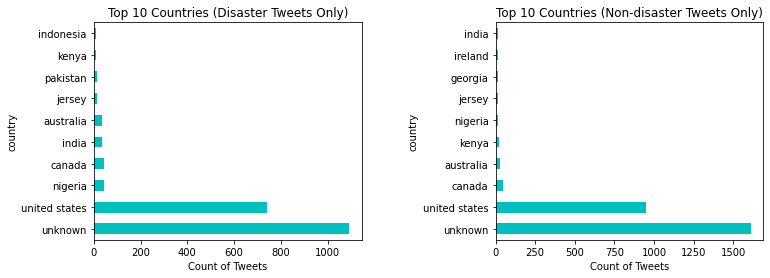

In [42]:
#segment and plot by tweet type

disaster_tweets = ldf.loc[df['target'] == 1]
dt = disaster_tweets[['country', 'location']].groupby('country').count().sort_values(by='location', ascending=False).head(10)

non_disaster_tweets = ldf.loc[df['target'] == 0]
ndt = non_disaster_tweets[['country', 'location']].groupby('country').count().sort_values(by='location', ascending=False).head(10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.subplots_adjust(wspace=.5)
#fig.suptitle('Tweets by Country')
dt.plot.barh(ax=ax1, color='c', legend=None)
ndt.plot.barh(ax=ax2, color='c', legend=None)

ax1.set_title('Top 10 Countries (Disaster Tweets Only)')
ax2.set_title('Top 10 Countries (Non-disaster Tweets Only)')
ax1.xaxis.set_label_text('Count of Tweets')
ax2.xaxis.set_label_text('Count of Tweets')
plt.show()

## Most Popular Bigrams



In [49]:
#CREDIT TO SOURCES: 
#https://stackoverflow.com/questions/21844546/forming-bigrams-of-words-in-list-of-sentences-with-python
#https://stackoverflow.com/questions/43473736/most-common-2-grams-using-python

from collections import Counter
from nltk.util import ngrams
from nltk import word_tokenize
# nltk.download('stopwords')

#create dataframe
tweets = df[['text', 'target']]

#segment disaster tweets
dt = tweets.loc[df['target'] == 1]
dt.columns = ['text', 'target']
dt = dt['text']

#segment non-disaster tweets
ndt = tweets.loc[df['target'] == 0]
ndt.columns = ['text', 'target']
ndt = ndt['text']

def count_top_bigrams(tweets):
  #import stop words
  stop_words = set(stopwords.words('english'))

  #clean tweets
  clean_tweets = [word_tokenize(text_clean(tweet)) for tweet in tweets]

  #tokenize tweets and exclude stop words
  token_list = []

  for tweet in clean_tweets:
    tokens = []
    for token in tweet:
      if token not in stop_words:
        tokens.append(token)
    token_list.append(tokens)

  #group tokens as bigrams
  bigram_list = []

  for token in token_list: 
    bigram = list(ngrams(token, 2))
    bigram_list.append(bigram)

  #count bigrams
  cnt = Counter()

  for tweet in bigram_list:
    for bigram in tweet:
      cnt.update(nltk.bigrams(bigram))

  top20 = cnt.most_common(20)
  return top20

#store output as dataframes
db = count_top_bigrams(dt)
disaster_bigrams = pd.DataFrame(db, columns=['bigram', 'count'])

ndb = count_top_bigrams(ndt)
non_disaster_bigrams = pd.DataFrame(ndb, columns=['bigram', 'count'])

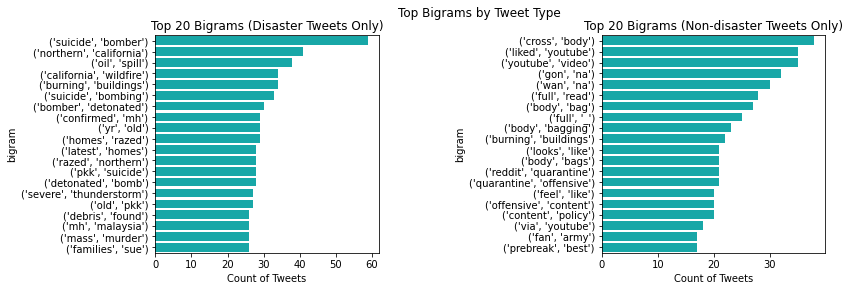

In [50]:
#segment and plot by tweet type
# print(disaster_bigrams)

fig, axes = plt.subplots(1, 2, figsize=(12,4))
fig.subplots_adjust(wspace=1)
fig.suptitle('Top Bigrams by Tweet Type')
sns.barplot(x = disaster_bigrams['count'], y = disaster_bigrams['bigram'], color='c', ax = axes[0])
sns.barplot(x = non_disaster_bigrams['count'], y = non_disaster_bigrams['bigram'], color='c', ax=axes[1])

axes[0].set_title('Top 20 Bigrams (Disaster Tweets Only)')
axes[1].set_title('Top 20 Bigrams (Non-disaster Tweets Only)')
axes[0].xaxis.set_label_text('Count of Tweets')
axes[1].xaxis.set_label_text('Count of Tweets')
plt.show()

### Because the available tags, keyword and location, are sparse and method of construction are unclear to us, we wanted to create new tags for the text that we may be able to train later on. 

In [ ]:
df_train['hashtag'] = df_train['text'].apply(lambda s: re.findall(r'#(\w+)', s))
df_train['mentions'] = df_train['text'].apply(lambda x: re.findall(r"@(\w+)", x))
df_train['links'] = df_train['text'].apply(lambda x: re.findall(r"http:\/\/(\w+)", x))
df_train['retweet'] = df_train['text'].apply(lambda x: "rt" in x.lower().split())

df_train['mentions_ind'] = df_train.mentions.apply(lambda y: 0 if len(y)==0 else 1)
df_train['hashtag_ind'] = df_train.hashtag.apply(lambda y: 0 if len(y)==0 else 1)
df_train['links_ind'] = df_train.links.apply(lambda y: 0 if len(y)==0 else 1)
df_train['retweet_ind'] = df_train.retweet.apply(lambda y: 0 if y == False else 1)

print(df_train.head(10))

     id             keyword        location  \
0  8367                ruin         Belfast   
1  4164               drown             NaN   
2  9232   suicide%20bombing             NaN   
3  7587            outbreak  Fukuoka, Japan   
4  8816              sirens       Hollywood   
5  9673             tornado         Midwest   
6  2538           collision             NaN   
7   798              battle             NaN   
8  7108            military          Alaska   
9  7228  natural%20disaster             NaN   

                                                text  target  \
0  And then I go a ruin it all with something awf...       0   
1        @GraysonDolan only if u let me drown you ??       0   
2  meek mill should join isis since he loves suic...       0   
3  Families to sue over Legionnaires: More than 4...       1   
4  @TravelElixir Any idea what's going on? I hear...       1   
5  (OK)  Severe Thunderstorm Warning issued Augus...       1   
6  my favorite lady came to our vo

In text classification problems, text pre-processing is a crucial part to prepping our data for analysis. This can be found in our text_clean function. Some pre-processing considerations we have made include:
* removing numbers, symbols, and punctuation
* standardizing to lowercase text
* remove stop words
* word stemming
* trailing spaces

# Preprocess
* Lemmatize: (study -> study, studies -> study)
* Stemmatize: (study -> study, studies -> studi)

In [ ]:
# Preprocess the data prior to running the model using this function
# TODO: Here I've commented out the punctuation regex section
# Feel free to uncomment that part BUT I think we should leave it out
# altogether. See below for usage.

#Ben - can you include the dropping of duplicates in the preprocessing function?
def drop_dup(df): 
    #remove duplicates 
    df.drop_duplicates(subset=['text'], keep='first')
    return df

def preprocess(text, method=None, tokenizer=sent_tokenize, rm_stop=False): 
    """Returns a text processed string.

    Arguments:
    text      -- String, func is designed for loops
    
    method    -- ('s','l') Specify from s - stemmatize, l - lemmatize.
                 None will mean you do not want to remove suffix.
                 
    tokenizer -- Any tokenizer function, from word to sentence to tweet.
                 Tokenizer must not be an object.method unless you
                 specifiy it to be like TweetTokenizer.tokenize.
                 Sentence tokenizer is initialized here.
                 
    rm_stop   -- Bool. Remove stop words or not.
    """

    #remove line breaks
    text = re.sub(r"\n","",text)
    # remove trailing spaces
    text = re.sub(r'[ \t]+$','', text)
    #convert to lowercase 
    text = text.lower()
    #remove digits and currencies 
    text = re.sub(r"\d+","",text) 
    text = re.sub(r'[\$\d+\d+\$]', "", text)
    #remove dates 
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    #remove non-ascii
    text = re.sub(r'[^\x00-\x7f]',r' ',text) 
    #remove hyperlinks
    #text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http\S+', '', text, flags=re.MULTILINE)

    #remove punctuation
    # Leave it? or talking point?!
    #text = re.sub(r'[^\w\s]','',text)
    
    if rm_stop:
        filtered_tokens = [word for word in tokenizer(text) 
                           if not word in set(stopwords.words('english'))]
        text = " ".join(filtered_tokens)
        
    if method == 'l':
        lemmer = WordNetLemmatizer()
        lemm_tokens = [lemmer.lemmatize(word) 
                       for word in tokenizer(text)]
        return " ".join(lemm_tokens)
    
    elif method == 's':
        porter = PorterStemmer()
        stem_tokens = [porter.stem(word) 
                       for word in tokenizer(text)]
        return " ".join(stem_tokens)
    return text

# Usage
### If someone wants to write a function that spits out all the possible model methods please do. This is to keep in mind that we are using K-folds CV to bag-> bootstrap our data.

In [ ]:
np.random.seed(0)
#df_ = df.sample(frac=1).reset_index()

# No stop word removal and no suffix cleaning. Naive Bayes example run
# I'll use CountVectorize in this to vectorize data.

df_ = df

# Process data in loop
processed_full = []
for i in df_.text:
    processed_full.append(preprocess(i))
df_.text = processed_full

# numtest = int(len(df_)/3.5)
# df_test = df_[:int(numtest/2)].reset_index(drop=True)
# df_dev = df_[int(numtest/2):numtest].reset_index(drop=True)
numtest = int(len(df_)/5)
df_train = df_[numtest:].reset_index(drop=True)
df_test = df_[:numtest].reset_index(drop=True) 

train_data, train_label = np.array(df_train.text), np.array(df_train.target)
dev_data, dev_label = np.array(df_dev.text), np.array(df_dev.target)
test_data, test_label = np.array(df_test.text), np.array(df_test.target)
# Naive Bayes example run
# I'll use TF-IDF in this to vectorize data.

tfidf = TfidfVectorizer()
t_data = tfidf.fit_transform(train_data)
dt_data = tfidf.transform(dev_data)
tt_data = tfidf.transform(test_data)
m_nb = MultinomialNB(alpha=0.9).fit(t_data, train_label)
pred = m_nb.predict(dt_data)
pred_test = m_nb.predict(tt_data)
print('Score on no SW removal, no suffix striping and TFIDF:')
print('F1 Score: {:.4f}'.format(metrics.f1_score(test_label, pred_test, average='weighted')))
print('Accuracy: {:.4f}'.format(metrics.accuracy_score(test_label, pred_test)))
print()


# Lemmatization, no stop words removal, Naive Bayes example run
# I'll use CountVectorize in this to vectorize data.

tokenizer = word_tokenize
df_ = df

processed_full = []
for i in df_.text:
    processed_full.append(preprocess(i,method='l',tokenizer=tokenizer,rm_stop=True))
df_.text = processed_full

numtest = int(len(df_)/5)
df_train = df_[numtest:].reset_index(drop=True)
df_test = df_[:numtest].reset_index(drop=True)

train_data, train_label = np.array(df_train.text), np.array(df_train.target)
dev_data, dev_label = np.array(df_dev.text), np.array(df_dev.target)
test_data, test_label = np.array(df_test.text), np.array(df_test.target)

tfidf = CountVectorizer(ngram_range=(1,1))
t_data = tfidf.fit_transform(train_data)
dt_data = tfidf.transform(dev_data)
tt_data = tfidf.transform(test_data)
m_nb = MultinomialNB(alpha=0.9).fit(t_data, train_label) # best alpha from project 3
pred = m_nb.predict(dt_data)
pred_test = m_nb.predict(tt_data)
print()
print('Test on Lemmatize, remove stop and CountVectorize:')
print('F1 Score: {:.4f}'.format(metrics.f1_score(test_label, pred_test, average='weighted')))
print('Accuracy: {:.4f}'.format(metrics.accuracy_score(test_label, pred_test)))

Score on no SW removal, no suffix striping and TFIDF:
F1 Score: 0.7702
Accuracy: 0.7720


Test on Lemmatize, remove stop and CountVectorize:
F1 Score: 0.7676
Accuracy: 0.7661


#### Clean the data and strip

### After the data has been cleaned and text pre-processed, we can begin exploring different algorithms. The three machine learning algorithms we will focus on are:
* Naive Bayes
* Logistic Regression
* SVM
* KMeans clustering